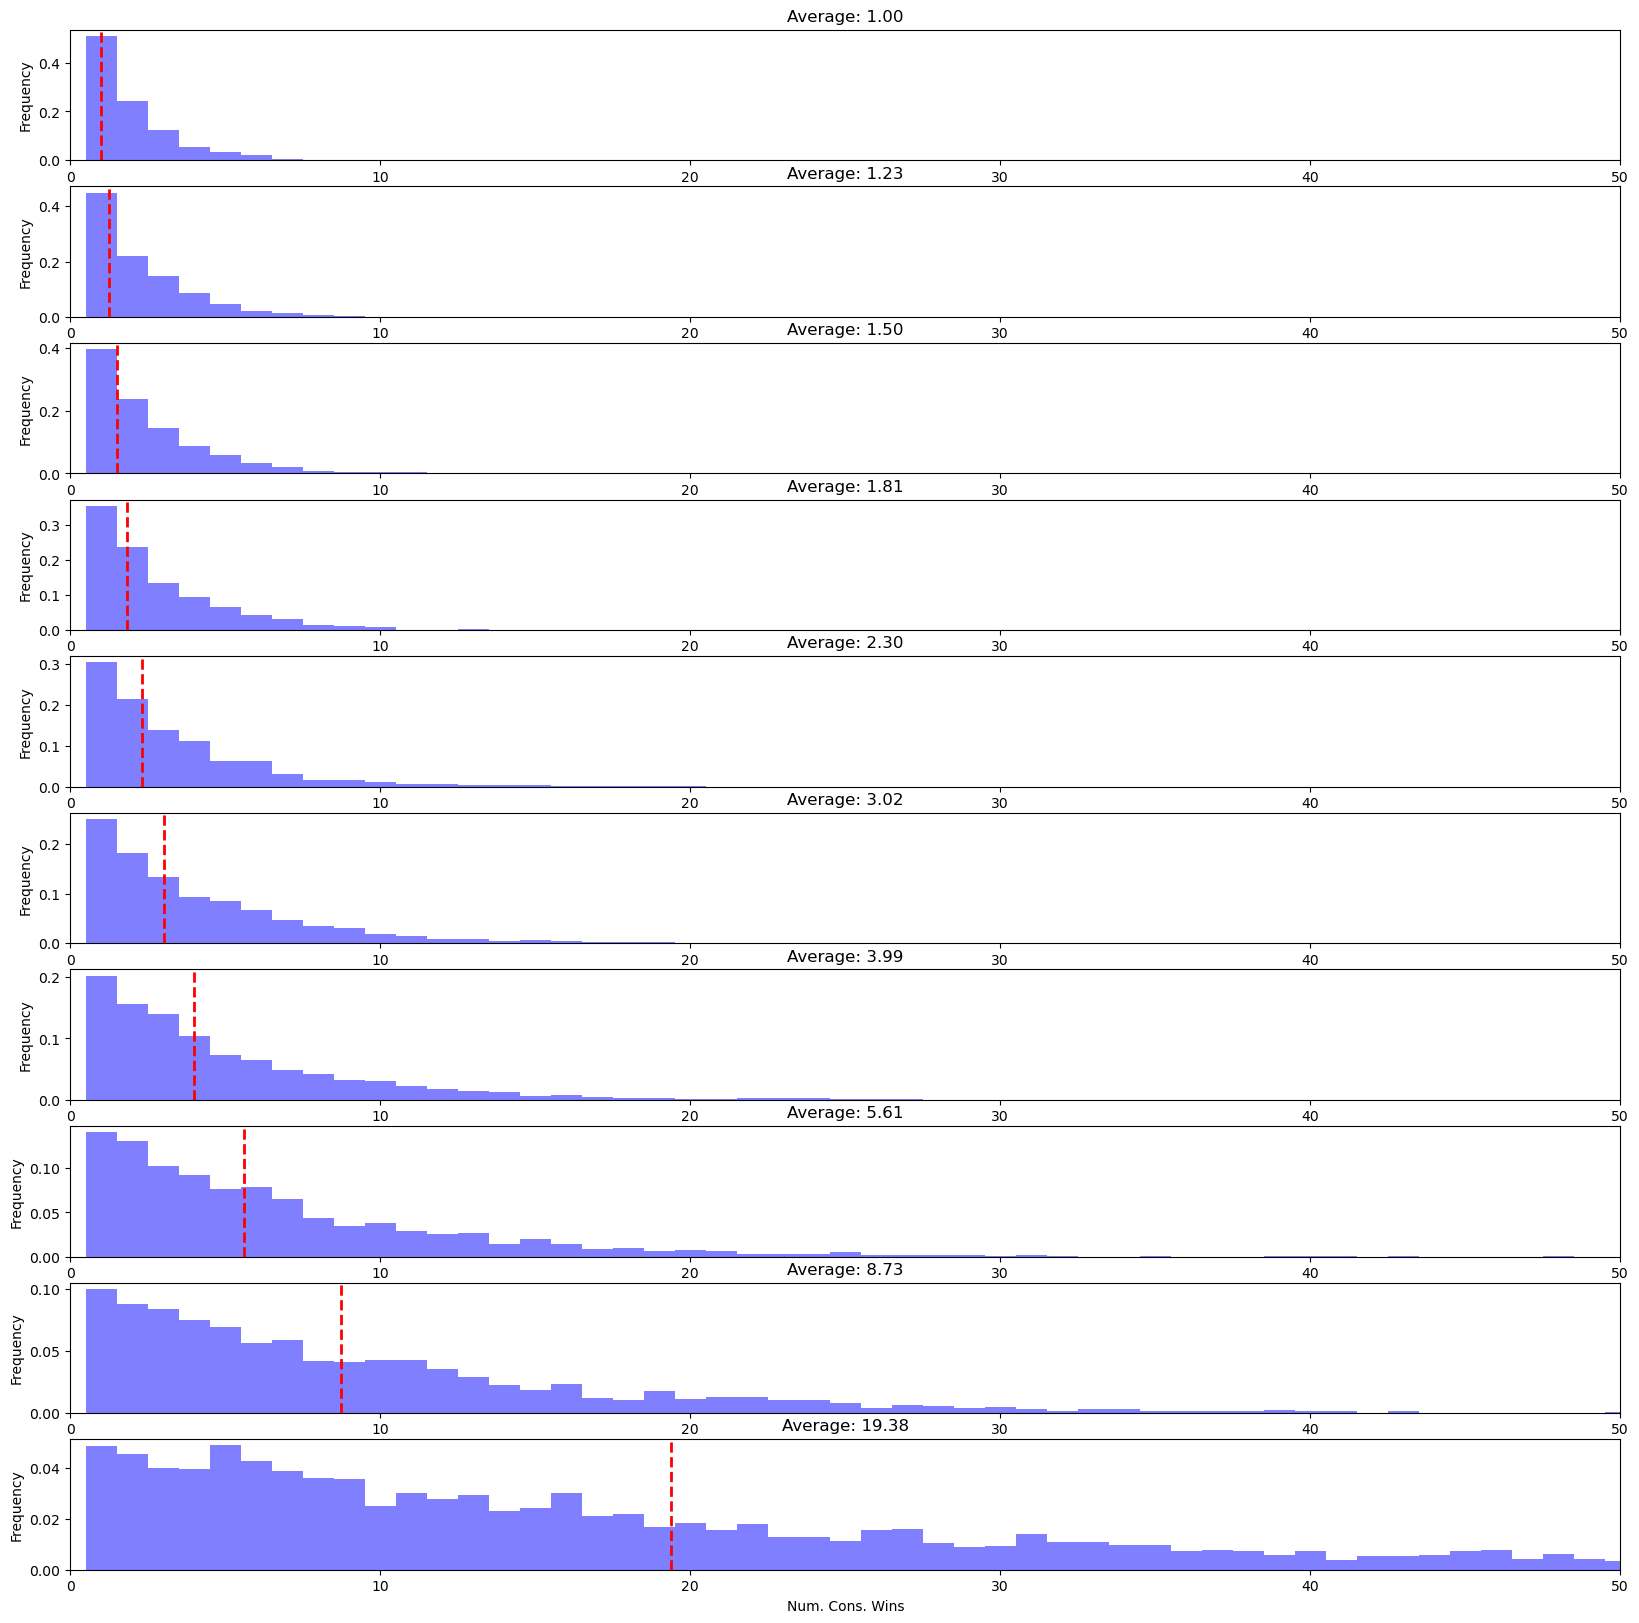

In [32]:
import numpy as np
import matplotlib.pyplot as plt

ngames = 2500

win_percentage = [0.05*i for i in range(10, 20)]

# Play a game until a loss and record number of consecutive wins
def play_game(wp):
    wins = 0
    while np.random.rand() < wp:
        wins += 1
    return wins

def play_set_of_games(win_percentage, ngames, do_plot=False):
    
    #print('Playing {} games for each win percentage'.format(ngames))
    #print('Win percentages: ', win_percentage)

    plot_number = 0
    avg_wins = []
    max_wins = []
    
    if (do_plot):
        fig, ax = plt.subplots(10, 1, figsize=(20, 20))
        
    for wp in win_percentage:
        # Simulate many games
        wins = [play_game(wp) for _ in range(ngames)]


        # Calculate average number of consecutive wins
        average_wins = np.mean(wins)
        avg_wins.append(average_wins)
        max_wins.append(np.max(wins))
        
        if do_plot:
            
            # create a histogram of the number of consecutive wins
            wins_hist = np.histogram(wins, bins=range(1, max(wins)+2), density=True)
            # Plot histogram of number of consecutive wins
            ax[plot_number].bar(wins_hist[1][:-1], wins_hist[0], width=1.0, color='blue', alpha=0.5)
            ax[plot_number].axvline(average_wins, color='red', linestyle='dashed', linewidth=2)
            ax[plot_number].set_xlabel('Num. Cons. Wins')
            ax[plot_number].set_ylabel('Frequency')
            ax[plot_number].set_title('Average: {:.2f}'.format(average_wins))
            ax[plot_number].set_xlim([0, 50])
        
        plot_number += 1
    
    return avg_wins, max_wins
    
avg_wins, max_wins = play_set_of_games(win_percentage, ngames, do_plot=True)

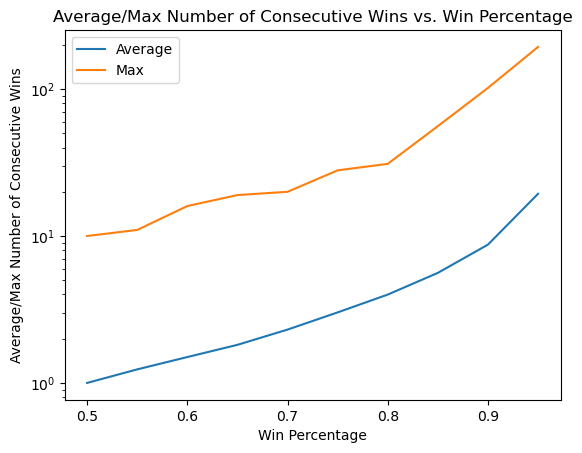

In [33]:
plt.plot(win_percentage, avg_wins, label='Average')
plt.plot(win_percentage, max_wins, label='Max')
plt.xlabel('Win Percentage')
plt.ylabel('Average/Max Number of Consecutive Wins')
plt.title('Average/Max Number of Consecutive Wins vs. Win Percentage')
plt.yscale('log')
plt.legend()

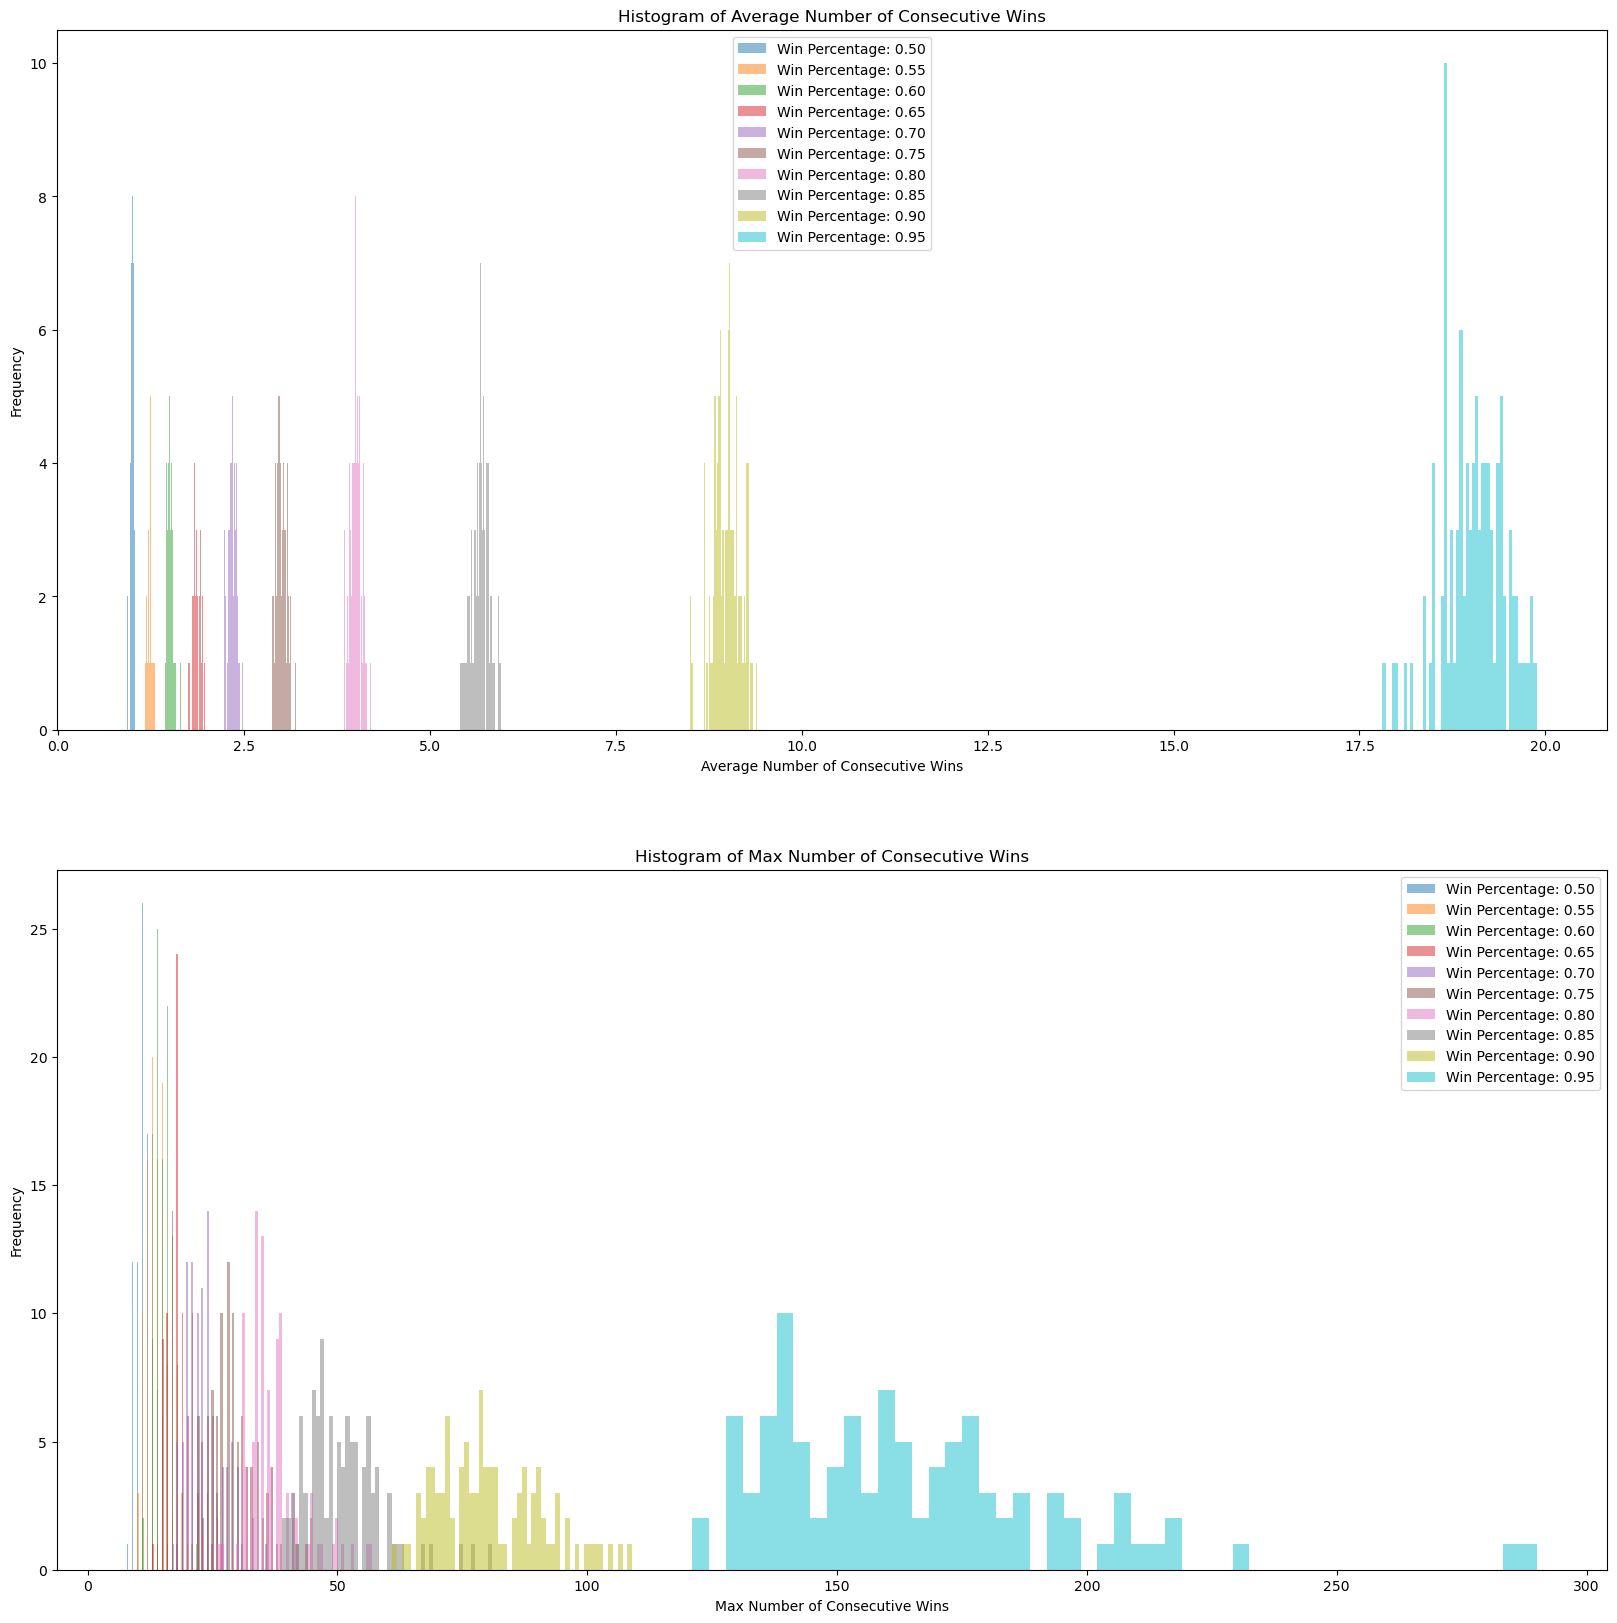

In [35]:
nsets = 100

avg_wins_sets = np.zeros((nsets, len(win_percentage)))
max_wins_sets = np.zeros((nsets, len(win_percentage)))

for i in range(nsets):
    avg_wins, max_wins = play_set_of_games(win_percentage, ngames)
    avg_wins_sets[i] = avg_wins
    max_wins_sets[i] = max_wins
    
# Create a histogram of the average number of consecutive wins and max wins for a specified win percentage

fig, ax = plt.subplots(2, 1, figsize=(20, 20))

for i in range(len(win_percentage)):
    ax[0].hist(avg_wins_sets[:, i], bins=50, alpha=0.5, label='Win Percentage: {:.2f}'.format(win_percentage[i]))
    ax[1].hist(max_wins_sets[:, i], bins=50, alpha=0.5, label='Win Percentage: {:.2f}'.format(win_percentage[i]))
    
ax[0].set_xlabel('Average Number of Consecutive Wins')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Average Number of Consecutive Wins')
ax[0].legend()

ax[1].set_xlabel('Max Number of Consecutive Wins')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Max Number of Consecutive Wins')
ax[1].legend()